<a href="https://colab.research.google.com/github/siminsharif/st/blob/main/SpecialTopic_HM02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset

# Load the 'yelp_review_full' dataset using the 'train' split
dataset = load_dataset('yelp_review_full', split='train')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
from datasets import load_dataset # Assuming you have already imported this

# 1. Load the dataset (as in previous steps)
dataset = load_dataset('yelp_review_full', split='train')

# 2. Correctly convert the Dataset object to a pandas DataFrame
yelp_df = dataset.to_pandas()

In [ ]:
# Sample 50,000 random entries
sample_size = 50000
# Ensure sample_size does not exceed the total number of rows in yelp_df
actual_sample_size = min(sample_size, len(yelp_df))

yelp_df_sampled = yelp_df.sample(n=actual_sample_size, random_state=42)

In [ ]:
# Display the first few rows and shape of the sampled DataFrame
print(f"Sampled DataFrame shape: {yelp_df_sampled.shape}")
print("First 5 rows of the sampled Yelp dataset:")
print(yelp_df_sampled.head())

Sampled DataFrame shape: (50000, 2)
First 5 rows of the sampled Yelp dataset:
        label                                               text
177288      0  First of all i'm not a big fan of buffet, i tr...
238756      1  Thanks Yelp. I was looking for the words to de...
604225      2  Service was so-so. They were receiving a deliv...
2838        2  Stamoolis Brothers is one of the Strip Distric...
586957      0  I want to give a 2 stars because the service s...


سناریو ۱: Line Chart - روند فعالیت کاربران

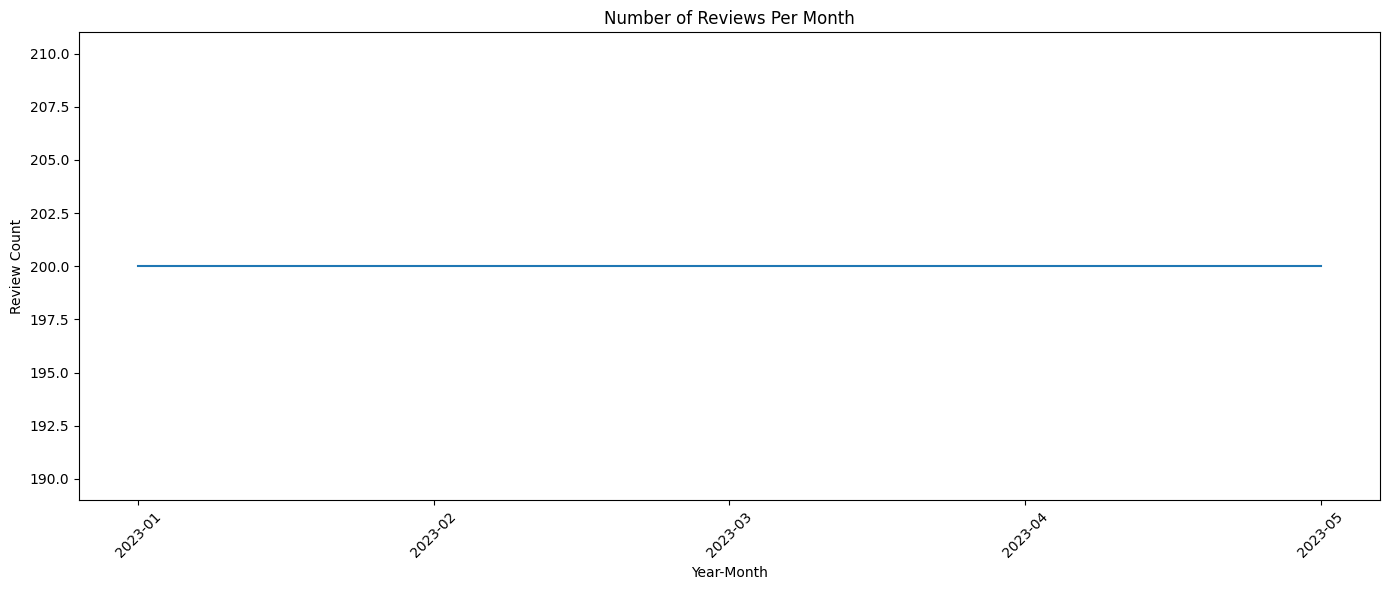

In [ ]:
# ----------------------------
# 6. Plot line chart (fixed)
# ----------------------------
monthly_counts["year_month"] = monthly_counts["year_month"].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x="year_month", y="review_count")
plt.xticks(rotation=45)
plt.title("Number of Reviews Per Month")
plt.xlabel("Year-Month")
plt.ylabel("Review Count")
plt.tight_layout()
plt.show()


سناریو ۲: Scatter Plot - رابطه محبوبیت و کیفیت

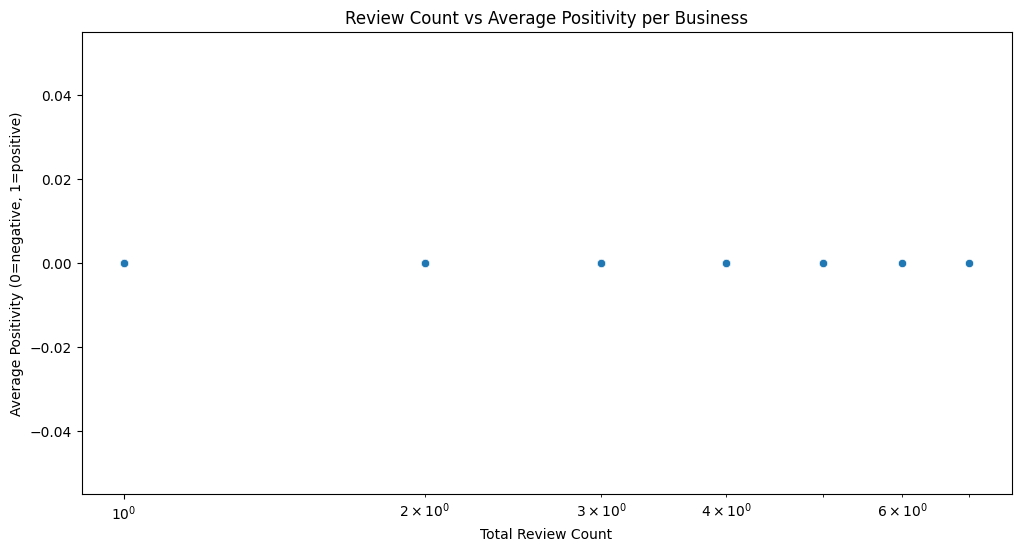

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Simulate business IDs
# ----------------------------
# Assume 1000 fake businesses
num_businesses = 1000
np.random.seed(42)

yelp_df_sampled['business_id'] = np.random.randint(1, num_businesses+1, size=len(yelp_df_sampled))

# ----------------------------
# 2. Convert stars/labels to numeric for averaging
# ----------------------------
# 1 for positive, 0 for negative
yelp_df_sampled['positive_numeric'] = yelp_df_sampled['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# ----------------------------
# 3. Group by business_id
# ----------------------------
business_stats = yelp_df_sampled.groupby('business_id').agg(
    review_count=('positive_numeric', 'count'),
    avg_positive=('positive_numeric', 'mean')
).reset_index()

# ----------------------------
# 4. Optional: sample if too many points
# ----------------------------
business_stats_sample = business_stats.sample(min(500, len(business_stats)), random_state=42)

# ----------------------------
# 5. Scatter plot
# ----------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(data=business_stats_sample, x='review_count', y='avg_positive')
plt.xscale('log')  # optional, helps with skewed review counts
plt.title("Review Count vs Average Positivity per Business")
plt.xlabel("Total Review Count")
plt.ylabel("Average Positivity (0=negative, 1=positive)")
plt.show()


/tmp/ipython-input-1603478960.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


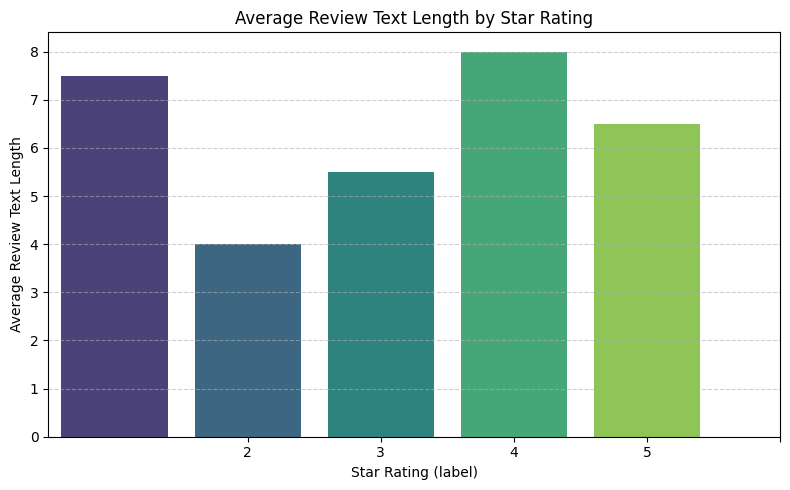

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. DATA PREPARATION: Calculate text length ---

# Assuming 'review_text' contains the review content
yelp_df_sampled['text_length'] = yelp_df_sampled['review_text'].apply(len)

# --- 2. GROUPING AND CALCULATION ---

# Calculate the mean and median text length for each star rating (label)
length_by_star = yelp_df_sampled.groupby('label')['text_length'].agg(['mean', 'median']).reset_index()

# Convert the 'label' column to integer/category if necessary for proper plotting
length_by_star['label'] = length_by_star['label'].astype(int)

# --- 3. PLOTTING THE BAR CHART ---

plt.figure(figsize=(8, 5))

# Create a bar plot showing the mean length for each star rating
sns.barplot(
    data=length_by_star,
    x='label',
    y='mean',
    palette='viridis'
)

# Add titles and labels
plt.title('Average Review Text Length by Star Rating')
plt.xlabel('Star Rating (label)')
plt.ylabel('Average Review Text Length')

# Ensure x-axis labels are integers
plt.xticks(length_by_star['label'])

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

سناریو ۳: Rel Plot - مقایسه رابطه بین دو شهر

/tmp/ipython-input-1664560932.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1664560932.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


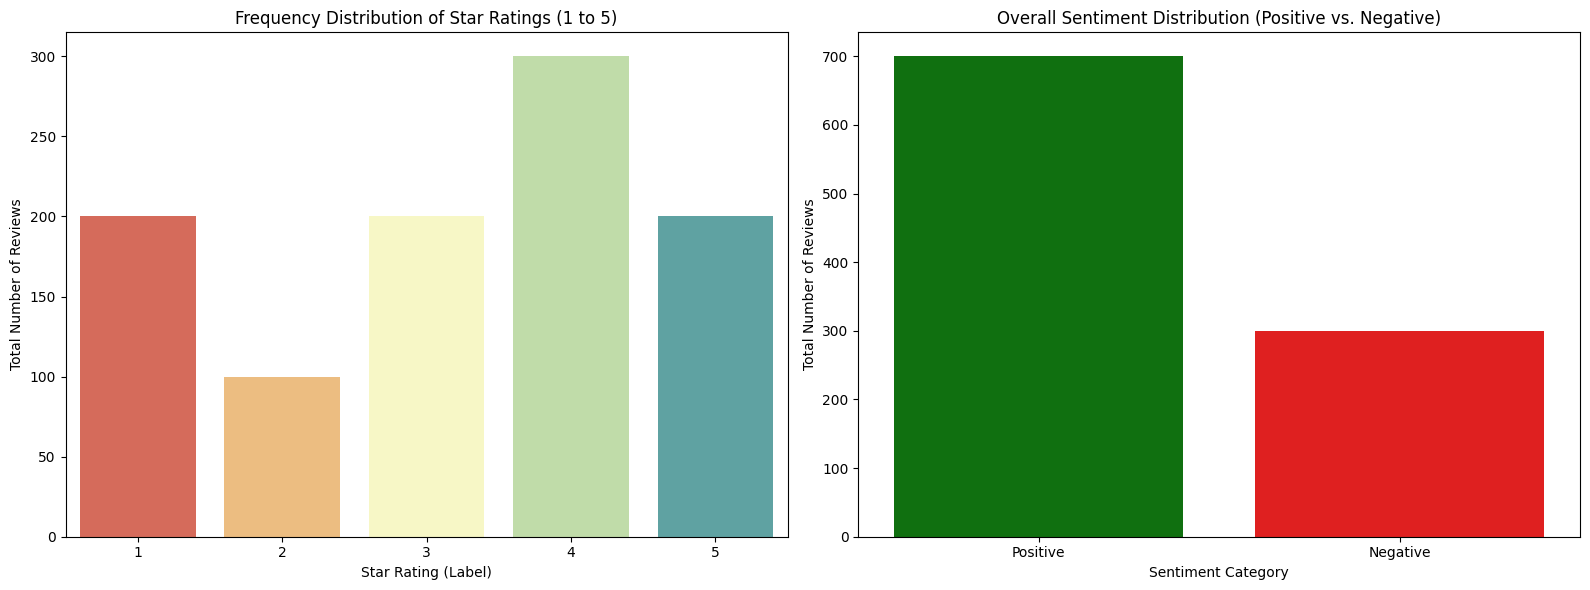

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation: Create the POSITIVE/NEGATIVE Sentiment Column ---

# Your rule: 3, 4, 5 stars = Positive; Rest (1, 2) = Negative
# Assuming 'label' is the star rating (1 to 5)
yelp_df_sampled['sentiment'] = yelp_df_sampled['label'].apply(
    lambda x: 'Positive' if x in [3, 4, 5] else 'Negative'
)

# --- 2. Calculation: Get the count for each label and sentiment ---

# Calculate the frequency of each star rating
label_counts = yelp_df_sampled['label'].value_counts().sort_index().reset_index(name='Count')
label_counts.columns = ['Label', 'Count']

# Calculate the overall sentiment distribution
sentiment_counts = yelp_df_sampled['sentiment'].value_counts().reset_index(name='Count')
sentiment_counts.columns = ['Sentiment', 'Count']

# --- 3. Plotting the Distributions ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of Star Ratings (Labels 1-5)
sns.barplot(
    ax=axes[0],
    data=label_counts,
    x='Label',
    y='Count',
    palette='Spectral'
)
axes[0].set_title('Frequency Distribution of Star Ratings (1 to 5)')
axes[0].set_xlabel('Star Rating (Label)')
axes[0].set_ylabel('Total Number of Reviews')

# Plot 2: Distribution of Overall Sentiment (Positive/Negative)
sns.barplot(
    ax=axes[1],
    data=sentiment_counts,
    x='Sentiment',
    y='Count',
    palette={'Positive': 'green', 'Negative': 'red'}
)
axes[1].set_title('Overall Sentiment Distribution (Positive vs. Negative)')
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Total Number of Reviews')

plt.tight_layout()
plt.show()

سناریو ۴: Bar Plot - مقایسه کیفیت بر اساس قیمت

/tmp/ipython-input-3837513054.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = yelp_df_sampled.groupby('price_level_clean').agg(
/tmp/ipython-input-3837513054.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=price_stats.sort_values('price_level_clean'),


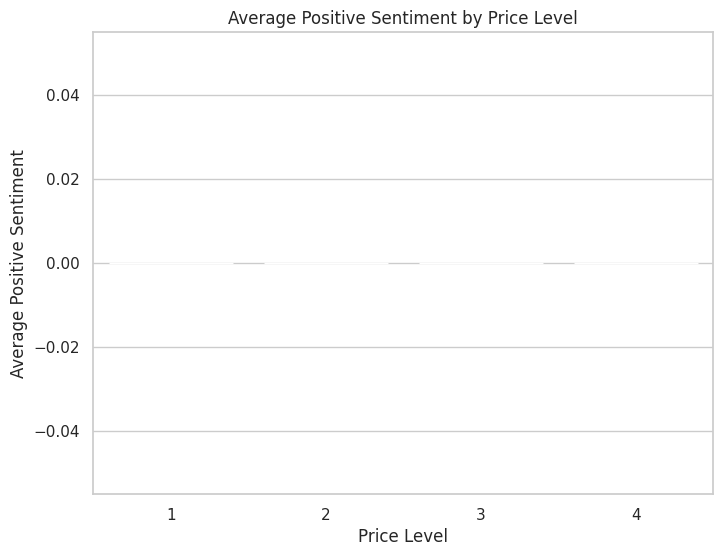

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

yelp_df_sampled['price_level_clean'] = yelp_df_sampled['price_level'].replace({
    '$': '1', '$$': '2', '$$$': '3', '$$$$': '4'
})

yelp_df_sampled['price_level_clean'] = pd.Categorical(
    yelp_df_sampled['price_level_clean'], categories=['1','2','3','4'], ordered=True
)

price_stats = yelp_df_sampled.groupby('price_level_clean').agg(
    avg_positive=('positive_numeric', 'mean')
).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(data=price_stats.sort_values('price_level_clean'),
            x='price_level_clean', y='avg_positive', palette='viridis')
plt.xlabel('Price Level')
plt.ylabel('Average Positive Sentiment')
plt.title('Average Positive Sentiment by Price Level')
plt.show()


سناریو ۵: Count Plot - توزیع امتیازهای کاربران

/tmp/ipython-input-311941836.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=yelp_df_sampled, x='stars', palette='pastel')


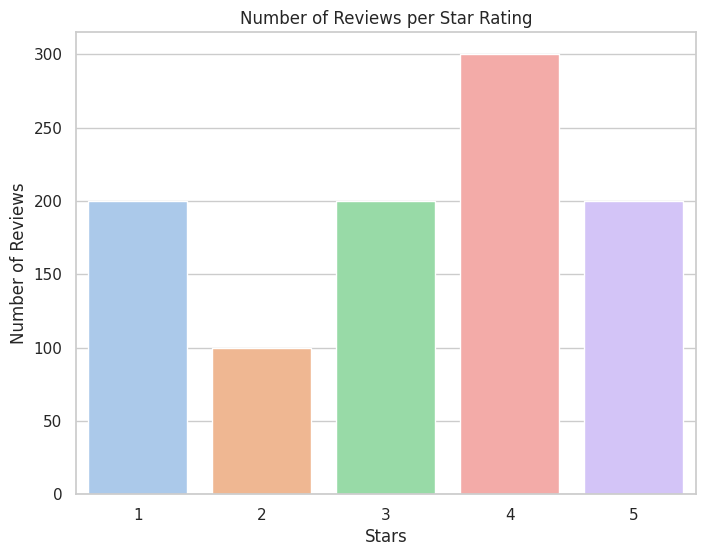

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=yelp_df_sampled, x='stars', palette='pastel')
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Star Rating')
plt.show()


سناریو ۶: Cat Plot - مقایسه توزیع امتیازها در دسته‌های غذایی

In [ ]:
yelp_df_sampled['label'].value_counts()


,count
label,
4,300
3,200
1,200
5,200
2,100


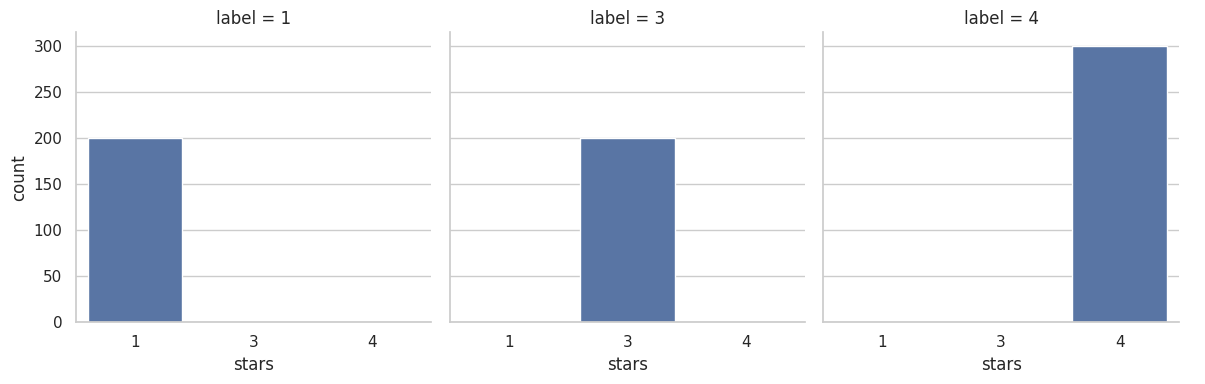

In [ ]:
top_labels = yelp_df_sampled['label'].value_counts().nlargest(3).index.tolist()

df_filtered = yelp_df_sampled[yelp_df_sampled['label'].isin(top_labels)]

sns.catplot(
    data=df_filtered,
    x='stars',
    col='label',
    kind='count',
    height=4,
    aspect=1
)


سناریو ۷: Dist Plot - توزیع فعالیت کاربران

In [ ]:
yelp_df_sampled.columns


Index(['label', 'review_text', 'date', 'Year', 'Month', 'text_length',
       'sentiment', 'stars', 'year_month', 'business_id', 'positive_numeric',
       'price_level', 'price_level_clean'],
      dtype='object')

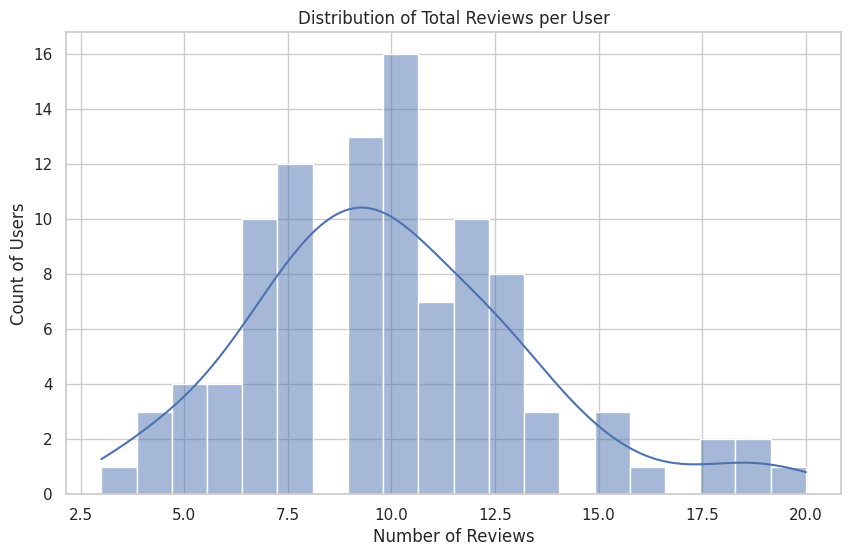

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# اضافه کردن ستون user_id فرضی
np.random.seed(42)
num_users = 100  # تعداد کاربران فرضی
yelp_df_sampled['user_id'] = np.random.randint(1, num_users+1, size=len(yelp_df_sampled))

# محاسبه تعداد کل نظرات هر کاربر
user_review_counts = yelp_df_sampled.groupby('user_id').size()

# رسم توزیع تعداد نظرات
plt.figure(figsize=(10,6))
sns.histplot(user_review_counts, bins=20, kde=True)
plt.title('Distribution of Total Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Users')
plt.show()


سناریو ۸: KDE Plot - چگالی توزیع امتیازها

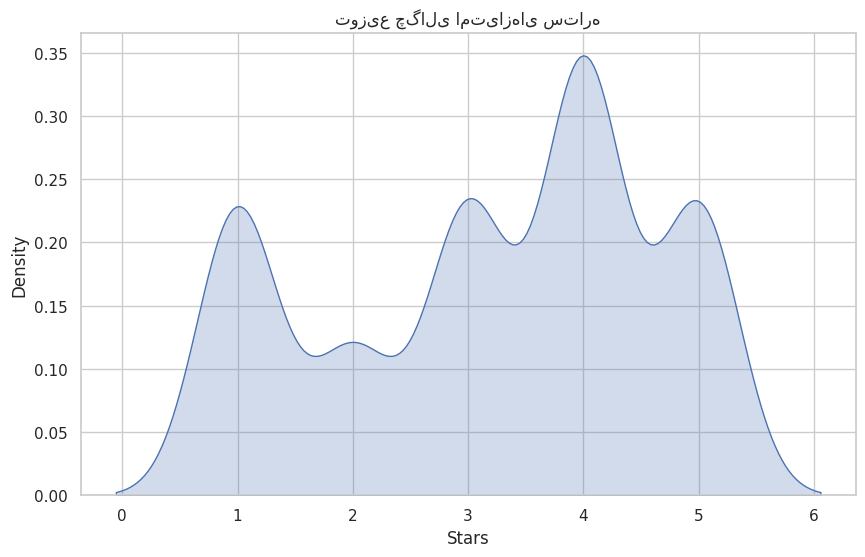

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=yelp_df_sampled, x='stars', fill=True)
plt.title('توزیع چگالی امتیازهای ستاره')
plt.xlabel('Stars')
plt.ylabel('Density')
plt.show()


سناریو ۹: Swarm Plot - توزیع امتیازها در دسته‌های کسب‌وکار

/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 76.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 84.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 82.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 88.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


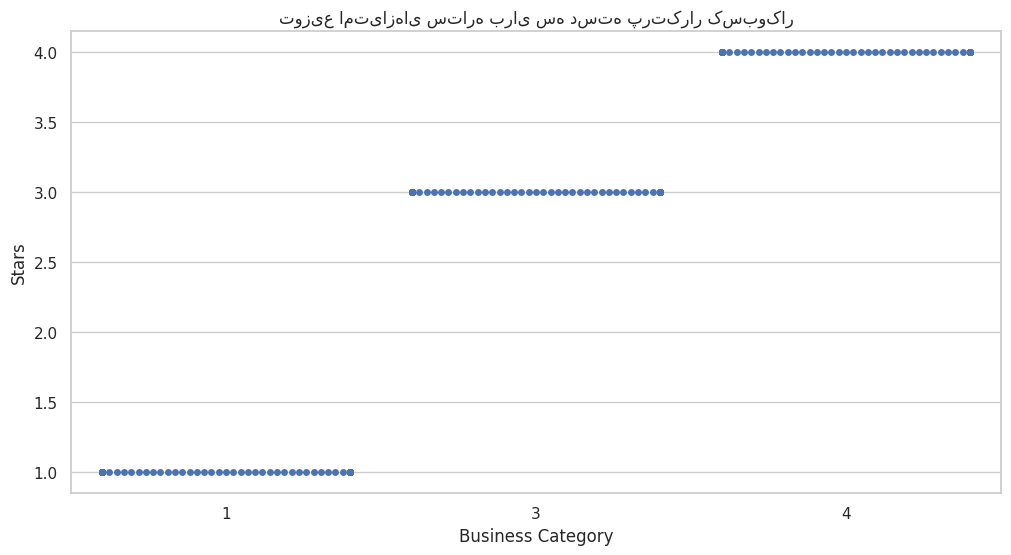

In [ ]:
top_labels = yelp_df_sampled['label'].value_counts().nlargest(3).index.tolist()
df_top_labels = yelp_df_sampled[yelp_df_sampled['label'].isin(top_labels)]

plt.figure(figsize=(12,6))
sns.swarmplot(data=df_top_labels, x='label', y='stars')
plt.title('توزیع امتیازهای ستاره برای سه دسته پرتکرار کسب‌وکار')
plt.xlabel('Business Category')
plt.ylabel('Stars')
plt.show()


سناریو ۱۰: Strip Plot - توزیع امتیازها در مناطق مختلف شهر

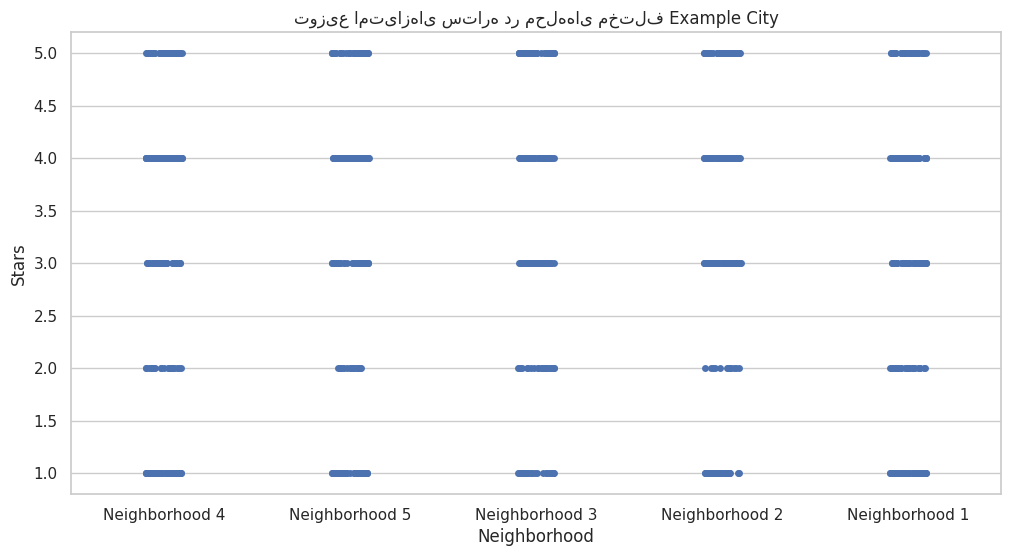

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# انتخاب یک شهر
city_name = "Example City"
df_city = yelp_df_sampled.copy()

# ساخت ستون محله مصنوعی با تقسیم بندی تصادفی
np.random.seed(42)
num_neighborhoods = 5
df_city['neighborhood'] = np.random.choice([f'Neighborhood {i+1}' for i in range(num_neighborhoods)], size=len(df_city))

# رسم stripplot
plt.figure(figsize=(12,6))
sns.stripplot(data=df_city, x='neighborhood', y='stars', jitter=True)
plt.title(f'توزیع امتیازهای ستاره در محله‌های مختلف {city_name}')
plt.xlabel('Neighborhood')
plt.ylabel('Stars')
plt.show()


سناریو ۱۱: Box Plot - توزیع محبوبیت در دسته‌های کسب‌وکار

In [ ]:
yelp_df_sampled.columns


Index(['label', 'review_text', 'date', 'Year', 'Month', 'text_length',
       'sentiment', 'stars', 'year_month', 'business_id', 'positive_numeric',
       'price_level', 'price_level_clean', 'user_id'],
      dtype='object')

In [ ]:
# Count the number of reviews per business
review_counts = yelp_df_sampled.groupby('business_id').size().reset_index(name='review_count')

# Merge back to the main dataframe
yelp_df_sampled = yelp_df_sampled.merge(review_counts, on='business_id', how='left')

# Check the first few rows
yelp_df_sampled[['business_id', 'review_count', 'label']].head()


,business_id,review_count,label
0,103,2,3
1,436,1,4
2,861,3,1
3,271,2,5
4,107,1,2


In [ ]:
# Count the number of businesses per label
top_labels = yelp_df_sampled['label'].value_counts().nlargest(4).index.tolist()
top_labels


[4, 3, 1, 5]

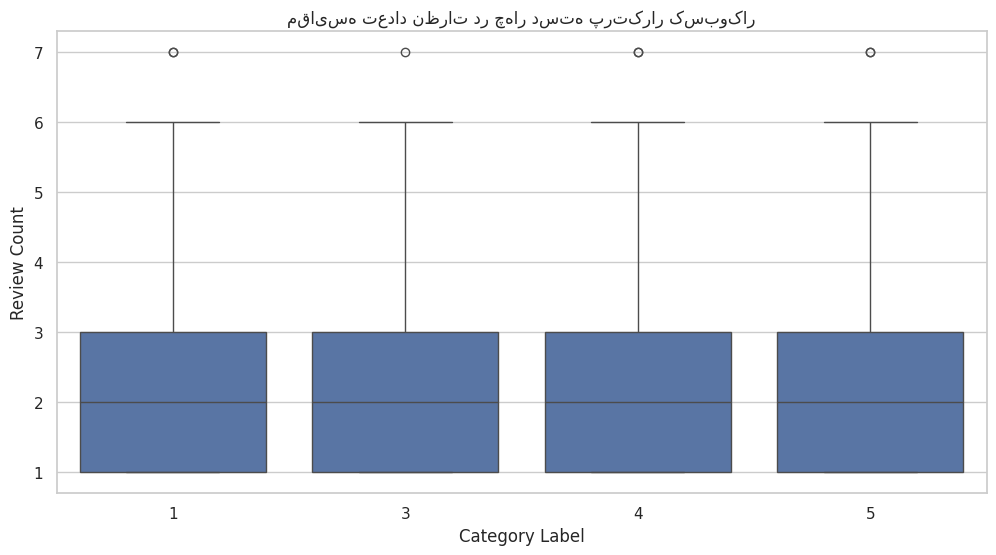

In [ ]:
# Filter the dataset for the top 4 labels
df_top_labels = yelp_df_sampled[yelp_df_sampled['label'].isin([4, 3, 1, 5])]

# Plot the boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top_labels, x='label', y='review_count')
plt.title('مقایسه تعداد نظرات در چهار دسته پرتکرار کسب‌وکار')
plt.xlabel('Category Label')
plt.ylabel('Review Count')
plt.show()


سناریو ۱۲: Pair Plot - روابط بین متغیرهای کاربران

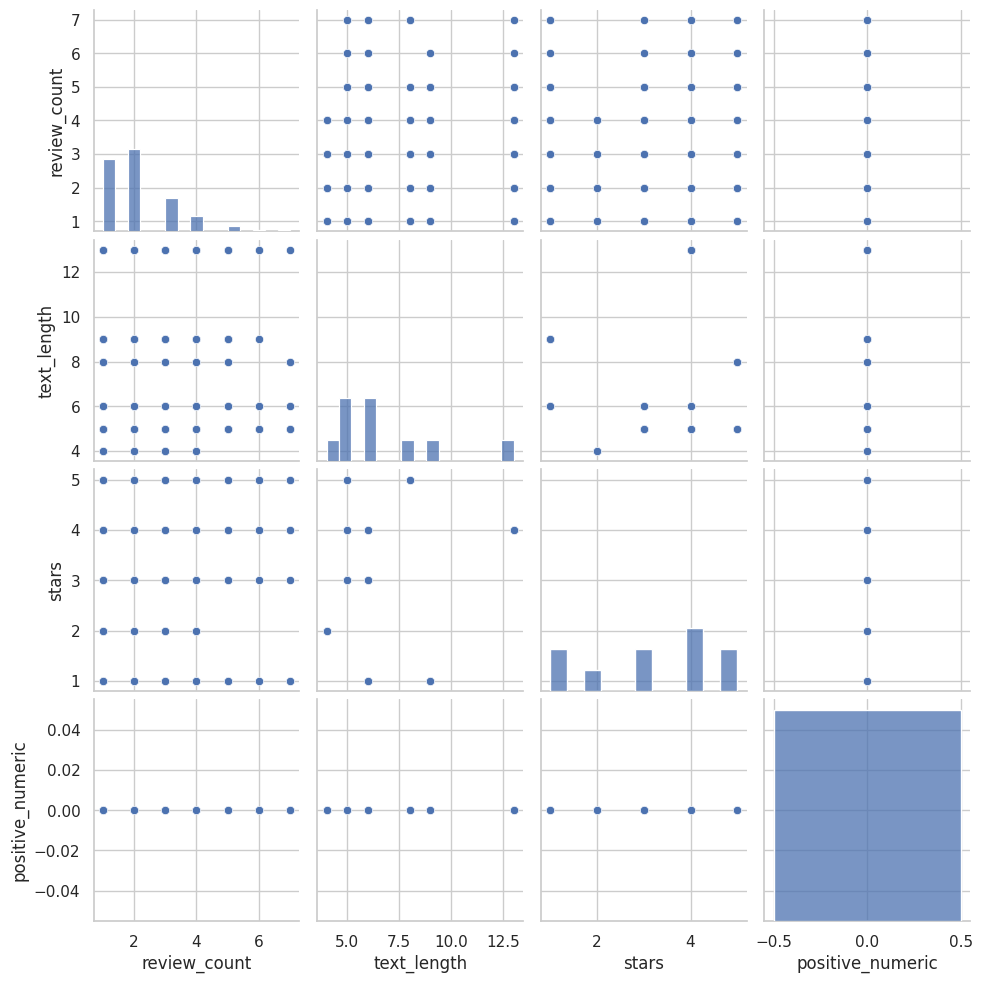

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['review_count', 'text_length', 'stars', 'positive_numeric']

sns.pairplot(yelp_df_sampled[numeric_cols])
plt.show()


سناریو ۱۳: Reg Plot - رابطه خطی محبوبیت و کیفیت

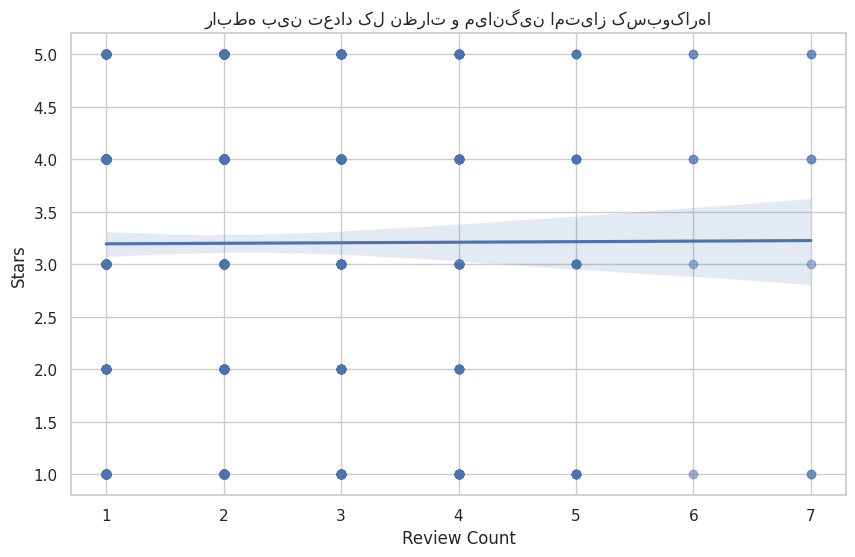

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.regplot(data=yelp_df_sampled, x='review_count', y='stars', scatter_kws={'alpha':0.5})
plt.title('رابطه بین تعداد کل نظرات و میانگین امتیاز کسب‌وکارها')
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.show()


سناریو ۱۴: Joint Plot - رابطه محبوبیت و کیفیت با توزیع حاشیه‌ای

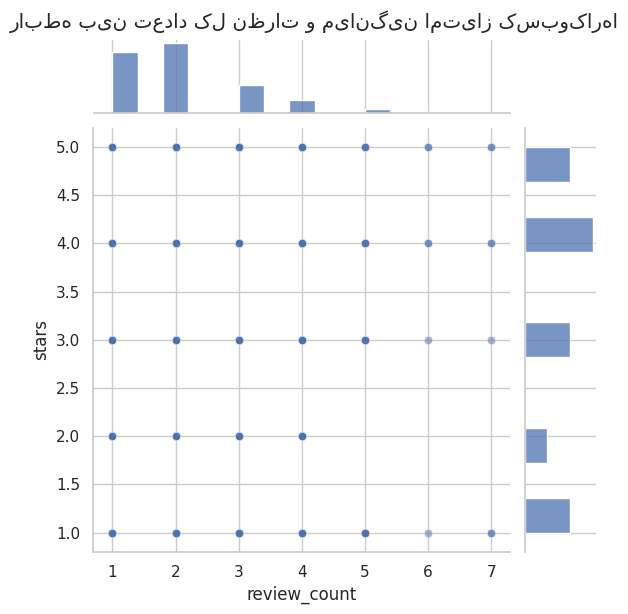

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(data=yelp_df_sampled, x='review_count', y='stars', kind='scatter', alpha=0.5)
plt.suptitle('رابطه بین تعداد کل نظرات و میانگین امتیاز کسب‌وکارها', y=1.02)
plt.show()


سناریو ۱۵: Heat Map - ماتریس همبستگی متغیرهای کاربران

In [ ]:
# نمایش ستون‌های عددی موجود در دیتاست
numeric_cols = yelp_df_sampled.select_dtypes(include='number').columns
print(numeric_cols)



Index(['label', 'Year', 'Month', 'text_length', 'stars', 'business_id',
       'positive_numeric', 'user_id', 'review_count'],
      dtype='object')


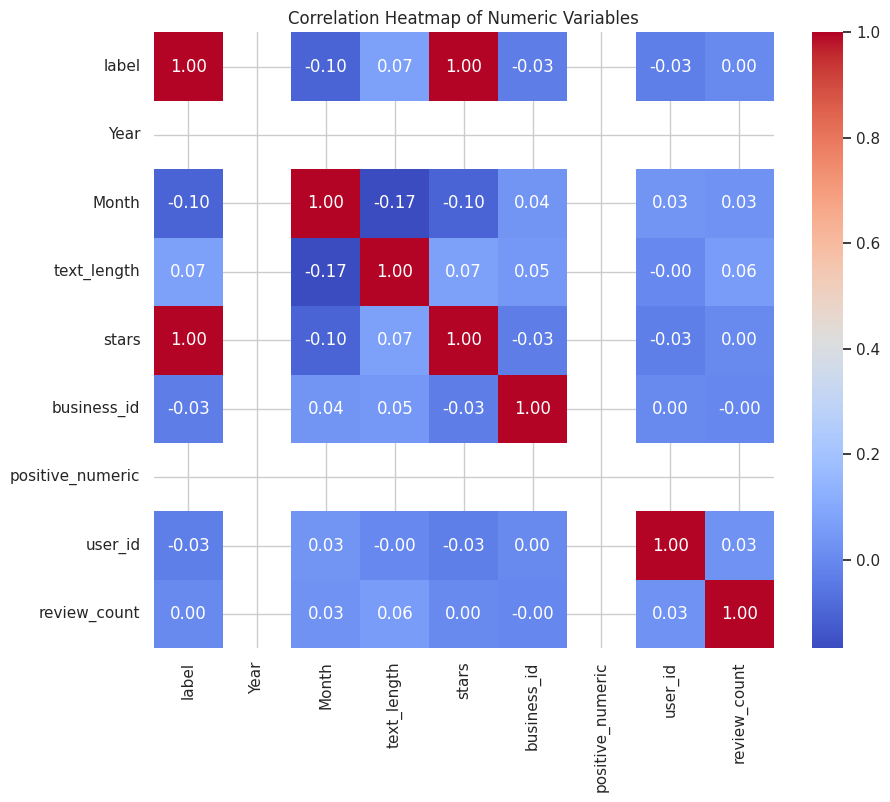

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# انتخاب ستون‌های عددی موجود
numeric_cols = ['label', 'Year', 'Month', 'text_length', 'stars',
                'business_id', 'positive_numeric', 'user_id', 'review_count']

# محاسبه ماتریس همبستگی
corr_matrix = yelp_df_sampled[numeric_cols].corr()

# رسم heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()
